In [27]:
import numpy as np
import itertools

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-poster')

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:

from MomentMatching.baseMomentMatch import MomentMatching, UnscentedTransform, TaylorTransform
from MomentMatching.TimeSeriesModel import TimeSeriesModel, UniformNonlinearGrowthModel
from MomentMatching.StateModels import GaussianState
from MomentMatching.ExpectationPropagation import EPNodes, TopEP

In [5]:
np.random.seed(seed=101)

In [6]:
N = 50
system = UniformNonlinearGrowthModel()
data = system.system_simulation(N)
x_true, x_noisy, y_true, y_noisy = zip(*data)

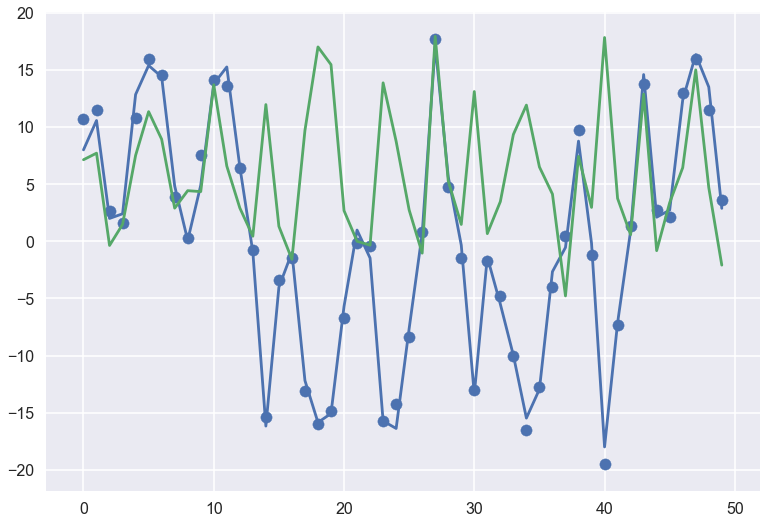

In [7]:
plt.plot(x_true)
plt.scatter(list(range(N)), x_noisy)
plt.plot(y_noisy)
plt.show()

In [8]:
transform = TaylorTransform(dimension_of_state=1)
transform = UnscentedTransform(n=1)
Nodes = EPNodes(dimension_of_state=1, N=N)
EP = TopEP(system_model=system, moment_matching=transform.moment_matching_KF)


In [9]:
prior = Nodes[0].copy()
prior.marginal = system.init_dist

In [10]:
EP.forward_update(Nodes[0], prior, 0.0)

<class 'MomentMatching.ExpectationPropagation.TimeSeriesNodeForEP'>.(t=0, state_dim=1,
    marginal_init=GaussianState 
 mean=
 [ 9.51240756], 
 cov=
[[ 56.95974439]]), factor_init=(GaussianState 
 mean=
 [ 0.], 
 cov=
[[ 99999.]]), GaussianState 
 mean=
 [ 0.], 
 cov=
[[ 99999.]]), GaussianState 
 mean=
 [ 9.5124075], 
 cov=
[[ 56.95974407]])))

In [38]:
def EP_update(self, Nodes, observations, fargs_list):
    prior = Nodes[0].copy()
    prior.marginal = self.system_model.init_dist
        # GaussianState(mean_vec=np.array([0.1]),
        #                            cov_matrix=0.1 * np.eye(1, dtype=float))
    node_iter, next_node_iter = itertools.tee(Nodes)
    next(next_node_iter, None)
    for node, next_node, obs, fargs in itertools.zip_longest(node_iter, next_node_iter, observations, fargs_list):
        pred_state = self.forward_update(node=node, prev_node=prior, fargs=fargs)
        corrected_state = self.measurement_update(pred_state, obs, fargs)
        
        if next_node is not None:
            smoothed_state = self.backward_update(corrected_state, next_node=next_node, fargs=fargs )
        else:
            smoothed_state = corrected_state
            
        yield smoothed_state
        prior = smoothed_state

In [39]:
def kalman_filter(self, Nodes, observations, fargs_list):
    prior = Nodes[0].copy()
    prior.marginal = self.system_model.init_dist
        # GaussianState(mean_vec=np.array([0.1]),
        #                            cov_matrix=0.1 * np.eye(1, dtype=float))

    for node, obs, fargs in zip(Nodes, observations, fargs_list):
        pred_state = self.forward_update(node=node, prev_node=prior, fargs=fargs)
        corrected_state = self.measurement_update(pred_state, obs, fargs)
        yield corrected_state
        prior = corrected_state

        


In [40]:
ans = kalman_filter(EP, Nodes, y_noisy, range(0, N))

In [43]:
ans2 = EP_update(EP, Nodes, y_noisy, range(0, N))
ep_data = list(ans2)

In [45]:
[x.marginal.cov for x in ep_data]

[array([[ -1.05936602e+09]]),
 array([[ -6.67590687e+09]]),
 array([[-58841700.00266892]]),
 array([[ -2.45768053e+08]]),
 array([[ -1.05979499e+10]]),
 array([[ -2.75818387e+10]]),
 array([[ -1.60593729e+09]]),
 array([[ -1.75234877e+09]]),
 array([[ -2.16442749e+08]]),
 array([[ -4.61302353e+09]]),
 array([[ -4.27153122e+09]]),
 array([[ -3.20484891e+09]]),
 array([[ -9.84413714e+08]]),
 array([[-24024515.4129245]]),
 array([[ -1.52606152e+10]]),
 array([[ -1.09621965e+09]]),
 array([[ -2.71006583e+10]]),
 array([[ -7.67406696e+08]]),
 array([[ -4.45055764e+10]]),
 array([[ -2.72203766e+09]]),
 array([[-60342157.88875104]]),
 array([[-16734379.75255639]]),
 array([[ -1.43592315e+10]]),
 array([[ -1.99274028e+09]]),
 array([[ -4.33626603e+09]]),
 array([[-470923.21304473]]),
 array([[-28178031.45488474]]),
 array([[ -6.83332177e+09]]),
 array([[ -2.13238881e+09]]),
 array([[ -2.46430787e+10]]),
 array([[ -6.33045430e+08]]),
 array([[ -3.87150177e+09]]),
 array([[ -1.50094674e+09]]),
 

In [13]:
x_filtered = list(ans)
x_filt_mean = [x.marginal.mean for x in x_filtered]

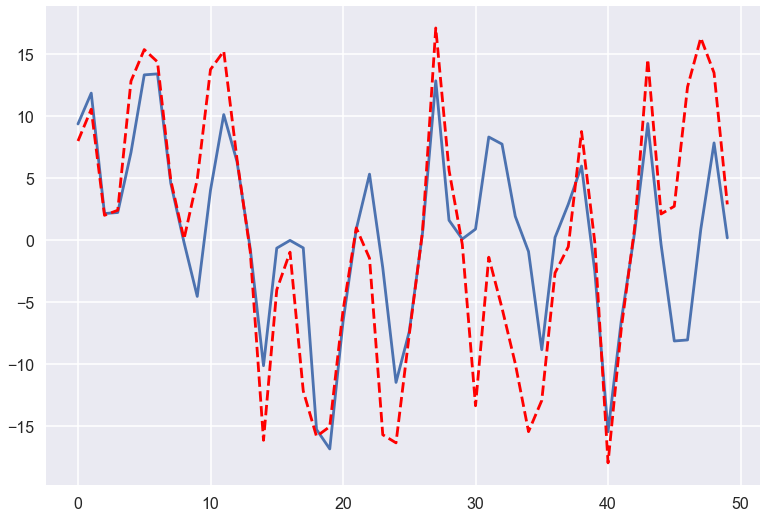

In [14]:
plt.plot(x_filt_mean)
plt.plot(x_true, 'r--', label='x_true')

In [15]:
def kalman_smoother(self, Nodes, fargs_list):
    
    reversedNodes = reversed(Nodes)
    reveresedFargs = reversed(fargs_list)
    
    # Last filtered value is same as first smoothed
    next(reveresedFargs)
    next_node = next(reversedNodes)
    yield next_node
    
    for node, fargs in zip(reversedNodes, reveresedFargs):

        smoothed_node = self.backward_update(node=node, next_node=next_node, fargs=fargs)
        yield smoothed_node
        next_node = smoothed_node
        

In [16]:
sms = kalman_smoother(EP, x_filtered, list(range(0, N)))
x_smoothed = (list(sms))

In [17]:

x_smoothed_mean = [x.marginal.mean for x in reversed(x_smoothed)]

In [23]:
[x.marginal.cov for x in reversed(x_smoothed)]

[array([[ 23.94079768]]),
 array([[-1.29474228]]),
 array([[ 1.77334316]]),
 array([[ 10.13237019]]),
 array([[ 42.31743661]]),
 array([[ 13.78737992]]),
 array([[ 1.34843949]]),
 array([[ 0.65266494]]),
 array([[-2.29308605]]),
 array([[ 102.13932639]]),
 array([[ 38.24780622]]),
 array([[ 19.15321345]]),
 array([[ 2.30203431]]),
 array([[-0.51029843]]),
 array([[ 216.84284662]]),
 array([[ 36.6664194]]),
 array([[-31.7756425]]),
 array([[-20.04936858]]),
 array([[ 117.80768021]]),
 array([[ 4.38553332]]),
 array([[ 1.14648011]]),
 array([[ 0.34441155]]),
 array([[ 517.95847383]]),
 array([[ 46.88834566]]),
 array([[ 29.40235235]]),
 array([[ 3.17740488]]),
 array([[ 1.05447778]]),
 array([[ 57.27381146]]),
 array([[ 30.8320601]]),
 array([[ 601.17295047]]),
 array([[ 34.76184992]]),
 array([[ 20.13833539]]),
 array([[ 6.24511838]]),
 array([[-97.35599314]]),
 array([[ 121.17382036]]),
 array([[ 84.17540497]]),
 array([[ 28.33945453]]),
 array([[ 8.18745399]]),
 array([[-50.97577735]]

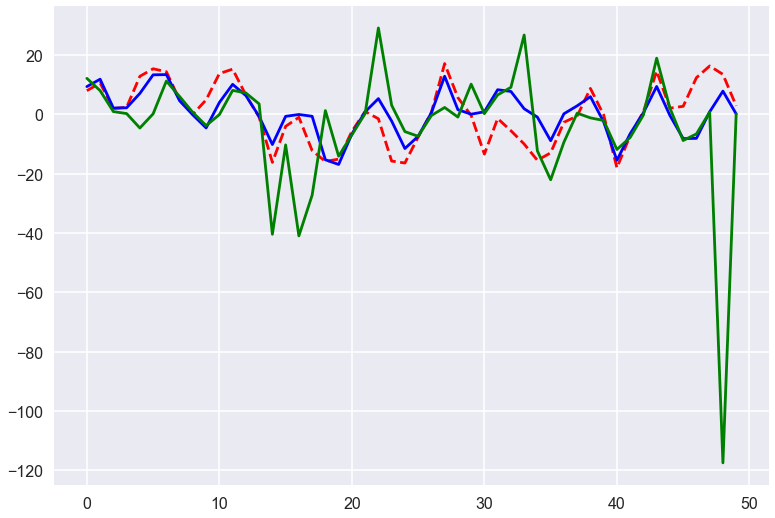

In [18]:
plt.plot(x_true, 'r--', label='x_true')
plt.plot(x_filt_mean, 'b', label='x_filtered')
plt.plot(x_smoothed_mean, 'g', label='x_smoothed')


In [22]:
ans = kalman_filter(EP, list(reversed(x_smoothed)), y_noisy, range(0, 10))
x_filtered2 = list(ans)

LinAlgError: Matrix is not positive definite

In [20]:

x_filt_mean2 = [x.marginal.mean for x in x_filtered2]

NameError: name 'x_filtered2' is not defined

In [ ]:
plt.plot(x_true, 'r--', label='x_true')
plt.plot(x_filt_mean, 'b', label='x_filtered')
plt.plot(x_smoothed_mean, 'g', label='x_smoothed')
plt.plot(x_filt_mean2, 'b--', label='x_smthd_filt')